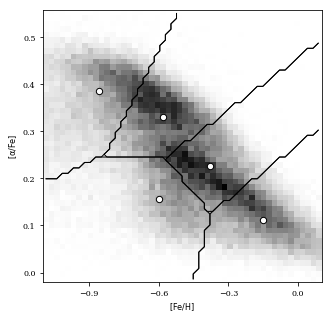

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 5

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()


[-1  0  1  2]
0.35
number of estimated clusters : 3
9
9


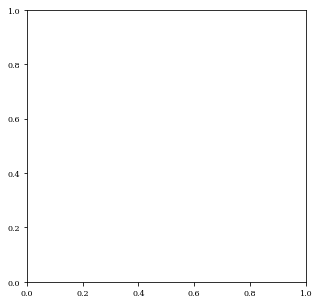

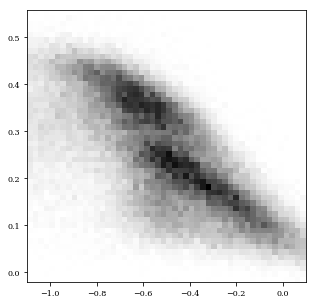

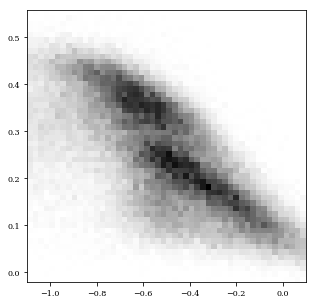

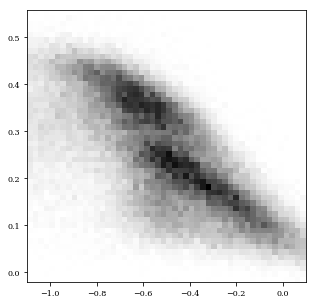

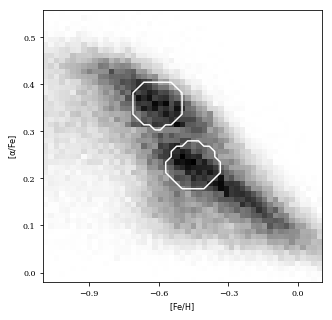

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from sklearn import mixture
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Get the data
np.random.seed(0)
data = fetch_sdss_sspp(cleaned=True)

# cut out some additional strange outliers
data = data[~((data['alphFe'] > 0.4) & (data['FeH'] > -0.3))]

X = np.vstack([data['FeH'], data['alphFe']]).T

#----------------------------------------------------------------------
# Compute clustering with MeanShift
#
# We'll work with the scaled data, because MeanShift finds circular clusters

X_scaled = preprocessing.scale(X)

# The following bandwidth can be automatically detected using
# the routine estimate_bandwidth().  Because bandwidth estimation
# is very expensive in memory and computation, we'll skip it here.


bandwidth = 0.35


ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(X_scaled)

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print labels_unique
print bandwidth
print "number of estimated clusters : %d" % n_clusters
# Fit a Gaussian mixture process using between 2-10 components
gmm=[]
for i in range(2,10):
    gmm.append(mixture.GaussianMixture(n_components=i,covariance_type='full').fit(X))
aic=[]
bic=[]
for i in range(0,len(gmm)):
    aic.append(gmm[i].aic(X))
    bic.append(gmm[i].bic(X))
#print the best number of mixture models to use according to AIC and BIC metrics
print (aic.index(min(aic))+2)
print (bic.index(min(bic))+2)
x = np.linspace(-2,2,1000)
y=np.linspace(-2,2,1000)
xy=[0]*len(x)
for i in range(0,len(x)):
    xy[i]=[x[i],y[i]]
#------------------------------------------------------------
# Plot the results
det=[0]*9
for i in range(0,9):
    det[i]=np.sqrt(np.linalg.det(gmm[7].covariances_[i]))
diff=np.ndarray(shape=(1000,9,2))
for j in range(0,9):
    for i in range(0,len(xy)):
        for k in range(0,2):
            diff[i][j][k]=xy[i][k]-gmm[7].means_[j][k]
        diff[i][j][:,].reshape(2,1)
sigma=np.ndarray(shape=(1000,9))
for j in range(0,9):
    for i in range(0,1000):
        sigma[i][j]=-0.5*(np.dot(diff[i][j][:,].T,np.dot(np.linalg.inv(gmm[7].covariances_[j]),diff[i][j][:,])))
    

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# plot density
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 51)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot clusters
colors = ['b', 'g', 'r', 'k']

for i in range(n_clusters):
    Xi = X[ms.labels_ == i]
    H, b1, b2 = np.histogram2d(Xi[:, 0], Xi[:, 1], (FeH_bins, alphFe_bins))

    bins = [0.1]

    ax.contour(0.5 * (FeH_bins[1:] + FeH_bins[:-1]),
               0.5 * (alphFe_bins[1:] + alphFe_bins[:-1]),
               H.T, bins, colors='w')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()


Above, we tried 3 clustering methods. The first is the k-means clustering, which works by choosing random center points for the given number of clusters. Then, we calculate distances to the centers from each data point. We then calculate a new cluster center by the formula v_i= 1/|c_i|\sum_i^|c_i|x_i where |c_i| is the number of points in the ith cluster. If the cluster center doesn't move, we stop the algorithm otherwise we repeat the process. The drawback here is we have to manually enter the number of clusters, when in reality this may not be known. On the other hand, the mean shift algorithm puts a PDF on the data points and then uses a gradient method to find the nearest local maxima for each point and groups it by local maxima. The drawback here is finded the estimated bandwidth, which determines the complexity of the PDF. In reality, the estimated bandwidth function is hugely computationally intensive. Lastly, we also fitted a GMM using between 2-10 mixture models. As the GMM is the most complex algorithm and computationally much less intensive than mean_shift, and we did not calibrate the mean_shift bandiwdth properly we beleive that 9 GMM will fit the data best. Both the AIC and the BIC agree that 9 clusters is the best parameter for the GMM. The AIC will prefer a computationally complex model while the BIC ensures that we do not overfit the data.  The figure for the GMM is below.


In [39]:
# compute 2D density
from astroML.plotting.tools import draw_ellipse

FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(map(np.ravel,
                     np.meshgrid(0.5 * (FeH_bins[:-1]
                                        + FeH_bins[1:]),
                                 0.5 * (alphFe_bins[:-1]
                                        + alphFe_bins[1:])))).T
log_dens=np.zeros(len(Xgrid))
for i in range(0,len(log_dens)):
    log_dens[i]=gmm[7].score_samples(Xgrid[i])
fig = plt.figure(figsize=(5, 1.66))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)
N=[2,3,4,5,6,7,8,9]
# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, aic, '-k', label='AIC')
ax.plot(N, bic, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.scatter(gmm[7].means_[:, 0], gmm[7].means_[:, 1], c='w')
for mu, C, w in zip(gmm[7].means_, gmm[7].covariances_, gmm[7].weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')



/home/sstueber/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sstueber/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/sstueber/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a

Text(0,0.5,u'$\\rm [\\alpha/Fe]$')

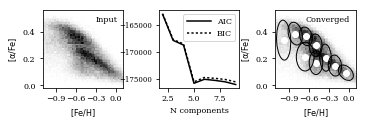

In [40]:
plt.show()